# Classifying crops in farms using machine learning
## Saber Dini 13/8/20

In this notebook, I explain how I used a Random Forest model to classify crops in farms using satellite images.

In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import pickle

### Reading in the dataset and exploring the data

In [2]:
data = pd.read_csv("./Images/pixels.csv")

In [3]:
# Remove any pixels that have a cloud value of over 2
data = data[data.cloud_prob <= 2]
# Creating X and y variables
X_all = data.iloc[:, :-3]
print(X_all.head())

      B01     B02     B03     B04     B05     B06     B07     B08     B8A  \
0  0.0724  0.0984  0.1148  0.1424  0.1523  0.1629  0.1765  0.1998  0.1959   
1  0.0752  0.0954  0.1172  0.1470  0.1560  0.1656  0.1809  0.2018  0.1996   
2  0.0752  0.0932  0.1142  0.1390  0.1560  0.1656  0.1809  0.1952  0.1996   
3  0.0752  0.0962  0.1178  0.1460  0.1560  0.1656  0.1809  0.2004  0.1996   
4  0.0752  0.0928  0.1136  0.1384  0.1560  0.1656  0.1809  0.1932  0.1996   

      B09     B11     B12  
0  0.2011  0.3177  0.2703  
1  0.2066  0.3224  0.2757  
2  0.2066  0.3224  0.2757  
3  0.2066  0.3224  0.2757  
4  0.2066  0.3224  0.2757  


In [4]:
y_all = data["label"]
# number of samples in each classe
print(y_all.value_counts())

Other      272879
Sorghum     13385
Cotton      11087
Name: label, dtype: int64


In [5]:
# Encoding y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_all_nu = le.fit_transform(y_all)

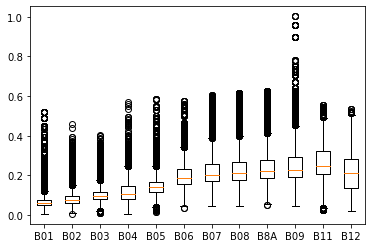

In [6]:
## Checking the distributions of the features
plt.boxplot(X_all)
plt.xticks(np.arange(np.shape(X_all)[1])+1, list(X_all.columns))
plt.show()

### Developing a Random Forest classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

In [8]:
# Parameter grid to feed into CV
param_grid = {
    'bootstrap': [False],
    'max_depth': [12, 18, 24, 30, 36, 42, None],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 1000, 1500, 2000]
}
# Creating the RF classifer
RF = RandomForestClassifier(oob_score = False, class_weight = 'balanced')
# Due to the signficant class imbalance StratifiedKFold should be used
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 123)

RF_cv = GridSearchCV(
    estimator=RF,
    param_grid = param_grid,
    scoring = 'balanced_accuracy',
    return_train_score = True,
    n_jobs = -1,
    cv=skf.split(X_all,y_all_nu)
)

In [9]:
# Running the cross validation or loading the results
pkl_filename = "RF_strcv_fine_results.pkl"
if False: # Change this to 'True' to run the CV which can take a while
    RF_cv_results = RF_cv.fit(X_all, y_all_nu)
    with open(pkl_filename, 'wb') as file:
        pickle.dump(RF_cv_results.best_estimator_, file)
else:
    with open(pkl_filename, 'rb') as file:
        # RF_cv_results = pickle.load(file)
        RF_cv_results = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=24,
                                               min_samples_leaf=2, min_samples_split=5,
                                               n_estimators=1000)

### Internal vaildation against the test set

In [10]:
# Fitting the RF to a training set and predicting the results for a test set
# (running this can take a while)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_nu, test_size=0.3, random_state=123)

fit_traindata = RF_cv_results.fit(X_train, y_train)

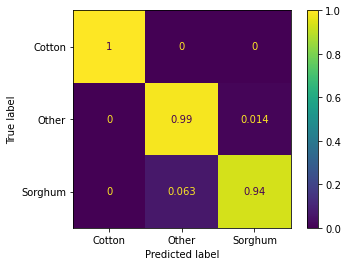

In [11]:
# Checking the performance for each class using the confusion matrix
confusion_matrix(y_true=y_test, y_pred=fit_traindata.predict(X_test), normalize="true")
# Plotting a confusion matrix
plot_confusion_matrix(fit_traindata, X_test, y_test, normalize="true")
plt.xticks([0, 1, 2], ["Cotton", "Other", "Sorghum"]) 
plt.yticks([0, 1, 2], ["Cotton", "Other", "Sorghum"]) 
plt.show()

### Prediction on the external test set

In [12]:
import PIL
def load_image(path):
    return np.array(PIL.Image.open(path))[:, :]

bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

data_dims = (np.size(load_image("Images/B01.tif")), len(bands))
data_test = pd.DataFrame(np.zeros(data_dims), columns=bands)
for i in bands:
    data_test.loc[:, i] = pd.Series(load_image("Images/" + i + ".tif").flatten())

data_train = pd.read_csv("./Images/pixels.csv")
data_train = data_train[data_train.cloud_prob <= 2]

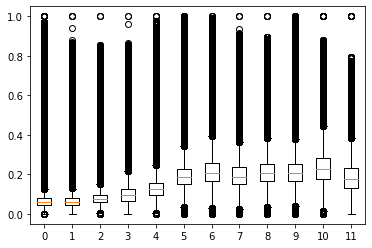

In [13]:
## Rescaling the test data         to fit the training data range
from sklearn.preprocessing import MinMaxScaler

data_test_sc = data_test.copy()

minmax_sc = MinMaxScaler()
data_test_sc = pd.DataFrame(minmax_sc.fit_transform(data_test_sc))

plt.boxplot(data_test_sc)
plt.xticks(np.arange(np.shape(X_all)[1])+1, data_test_sc.columns.tolist())
plt.show()

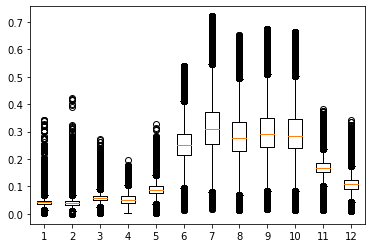

In [14]:
# Importing the mask file
img_mask = load_image("./Images/mask.png")
#print(img_mask.shape)
# Creating a matrix whose elements are 0 if all R=0, G=0 and B=0 and >0 otherwise
index_mask = img_mask[:,:,0] + img_mask[:,:,1] + img_mask[:,:,2]
index_mask = index_mask.flatten()

data_test_sc_masked = data_test_sc.loc[index_mask>0, :]
# data_test_sc_masked.describe()

plt.boxplot(data_test_sc_masked)
plt.show()

The distribution of features of masked data set seem to be quite different from the training set which is alarming! I think we need to know exactly what scaling function you used for scaling the training set. This may have a great negative impact on classification results.

In [15]:
# Prediction on the external test set using the RF
pred_testdata = RF_cv_results.predict(data_test_sc_masked)

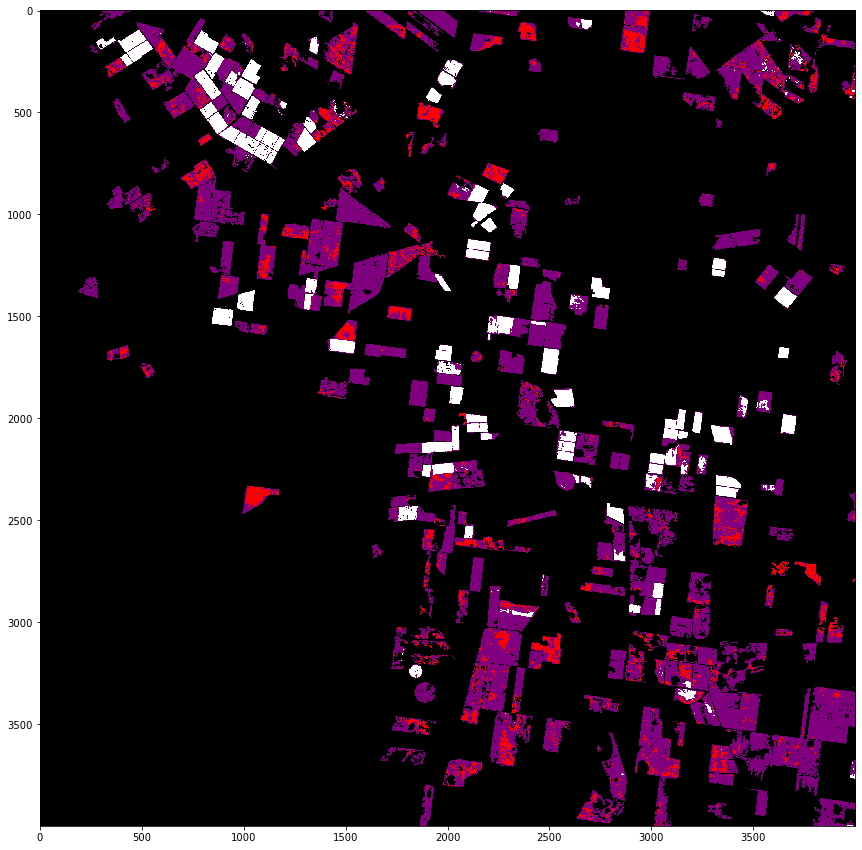

In [16]:
# create a blank image
pred_img_flat = np.full((np.shape(data_test_sc)[0], ), 3)
pred_img_flat[index_mask>0] = pred_testdata

im_size = np.shape(load_image("Images/B01.tif"))
pred_testdata_img = np.reshape(pred_img_flat, im_size)


from matplotlib import colors
# 0: Cotton; 1: Other; 2: Sorghum; 3: masked
cmap = colors.ListedColormap(['white', 'purple', 'red', 'black'], 'indexed')
plt.figure(figsize=(15, 15))
plt.imshow(pred_testdata_img, cmap=cmap, interpolation='none')

## Discussion

Overall, the model performs well on the internal test set as the prediction accuray is above 0.9 for all classes. The model performs perfectly in predicting 'Cotton' and struggles a bit in distinguishing 'Other' from 'Sorghum'. Plotting the density functions of features stratified by class shows that density functions of 'Other' and 'Sorghum' overlap quite a bit for all of the features, contrary to those for 'Cotton' that are perfectly segregated from the other classes.

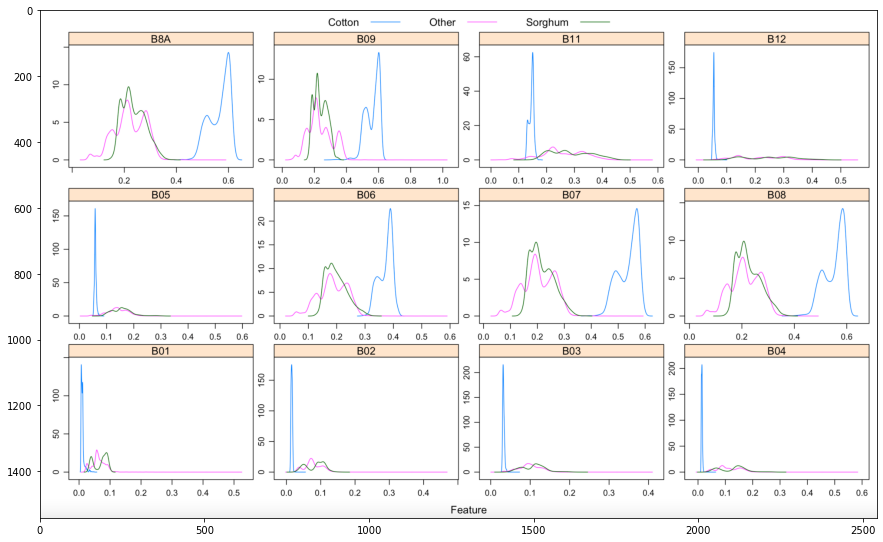

In [17]:
plt.figure(figsize=(15, 10))
img = mpimg.imread('./densityplot.png')
imgplot = plt.imshow(img)
plt.show()

Therefore, the main challenge of this classification problem seems to be the discrimination of 'Other' from 'Sorghum'. Hence, the efforts to improve the accuracy, either through selection of a better model or feature engineering, must be focused on that. In terms of selecting a model, I'm not sure if there is a hard and fast way to say exactly what method is better right off the bat, thus at the end of the day we may need to try various models and compare their performances. Theoretically, selecting a model is our assumption about the way features interact with each other and produce the outcome, for example when you use a linear model, you are assuming your features combine in a linear fashion and produce the outcome which is clearly not a feasible assumption in your problem (but it works for a lot of our epidemiological problems that features indeed are linearly correlated with e.g. a disease). I acutually tried a regularised logistic regression on the data and the results were not as good. Seeing the complex overalying patterns of density functions for 'Other' and 'Sorghum' clearly asks for a nonlinear model that can capture the subtle differences between the two classes.

Regarding feature engineering, as hinted by the instructions, trying different interactions between the features, e.g. multiplying or subtracting different pairs of (normalised) features, with the aim to separate the density of the two classes sound like a good idea. Adding new features or, in general, more information into the modelling process is another way that may help improving performance. For example, currently, the spatial structure of pixels in the images are not incorporated in the modelling and that can be very important because the values of pixels spatially closer to each other are probably highly correlated, since for example if a pixel at a certain location is from a corn farm, there is a higher chance that the adjacent ones are corn farms too. A convolutional neural network is a good candidate for accommodating the spatial structure in the images.

Can we further improve the model performance? Perhaps yes. Because of time, I couldn't spend a lot of time on parameter tuning using cross validation, but trying a larger and finer grid of parameter values would probably let us find a better parameter set with the cost of higher computation intensity. The way my parameter grid was selected was that I first started with a very coarse, wide grid and then narrowed it down to the parameter space where I was getting a better performace. Trying XGBoost using decision trees as learners would be an avenue to look into, because Random Forest is already doing good, so using the same model structure combined with boosting instead of bagging might improve the performance.